In [1]:
import pandas as pd
import os
import warnings
from chembl_webresource_client.new_client import new_client as client
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
import pubchempy as pcp
import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

In [2]:
warnings.filterwarnings("ignore")

In [3]:
working_dir = os.getcwd()
# dir for useful stuff for the actual essay
graphs_rel_path = r"project_results\graphs"
project_results_graphs = os.path.join(working_dir, graphs_rel_path)

In [4]:
def abs_file_path(rel_path):
    working_dir = os.getcwd()
    abs_file_path = os.path.join(working_dir, rel_path)
    return abs_file_path

In [5]:
RLM_rel_path = r"project_resources\AID_1508591_datatable_all.csv"
RLM_abs_path = abs_file_path(RLM_rel_path)
RLM_df = pd.read_csv(RLM_abs_path)
# loads csv file from directory
# !!!DO ZVLÁŠTNÍHO SOUBORU SPOLU S KAŽDÝM DALŠÍM VOLÁNÍM FCÍ!!!
# !!!ZDE POUZE DEFINICE!!!

In [6]:
RLM_filtered_abs_path = r"project_resources\RLM.csv"
RLM_df["Half-life (minutes)"] = RLM_df["Half-life (minutes)"].replace({">30": '30'})
RLM_df.to_csv(RLM_filtered_abs_path, index=False)
RLM = pd.read_csv(RLM_filtered_abs_path)
# creates a csv file with half life values >30 replaced with 30
# !!!DO ZVLÁŠTNÍHO SOUBORU SPOLU S KAŽDÝM DALŠÍM VOLÁNÍM FCÍ!!!
# !!!ZDE POUZE DEFINICE!!!

In [7]:
HLC_abs_path = r"project_resources\AID_1508603_datatable_all.csv"
HLC = pd.read_csv(HLC_abs_path)
# !!!DO ZVLÁŠTNÍHO SOUBORU SPOLU S KAŽDÝM DALŠÍM VOLÁNÍM FCÍ!!!
# !!!ZDE POUZE DEFINICE!!!

In [10]:
chembl_csv_abs_file_path = abs_file_path(r"project_resources\chembl_molekuly.csv")
# !!!DO ZVLÁŠTNÍHO SOUBORU SPOLU S KAŽDÝM DALŠÍM VOLÁNÍM FCÍ!!!
# !!!ZDE POUZE DEFINICE!!!

In [11]:
chembl_df = pd.read_csv(chembl_csv_abs_file_path, sep=";")
result = chembl_df[(chembl_df["Standard Type"] == "t1/2") | (chembl_df["Standard Type"] == "T1/2")]
t_half_rel_path = r"project_resources\t_half.csv"
t_half_abs_path = os.path.join(working_dir, t_half_rel_path)
result.to_csv(t_half_abs_path, index=False)
# creates "t_half.csv" in current dir
t_half = pd.read_csv(t_half_abs_path)
# and then loads it
# !!!DO ZVLÁŠTNÍHO SOUBORU SPOLU S KAŽDÝM DALŠÍM VOLÁNÍM FCÍ!!!
# !!!ZDE POUZE DEFINICE!!!

In [39]:
def smiles_from_mol_id(list_mol_id, database, isozyme):
    list_smiles = []
    smiles_csv_rel = r"project_resources\smiles.csv"
    smiles_csv_abs = os.path.join(working_dir, smiles_csv_rel)

    # Check if SMILES CSV file exists
    if not pathlib.Path(smiles_csv_abs).is_file():
        with open(smiles_csv_abs, "w") as empty_csv:
            pass
        smiles_csv = pd.DataFrame()
    else:
        # Read SMILES CSV file
        smiles_csv = pd.read_csv(smiles_csv_abs, index_col=0)

    try:
        list_smiles = smiles_csv[isozyme].values
    except KeyError or ValueError:
        if database == "ChEMBL":
            for chembl_id in list_mol_id:
                molecule = client.molecule
                compound = molecule.filter(chembl_id=chembl_id)[0]
                list_smiles.append(compound['molecule_structures']["canonical_smiles"])

        if database == "PubChem":
            for cid in list_mol_id:
                compound = pcp.Compound.from_cid(cid)
                smiles = compound.isomeric_smiles
                list_smiles.append(smiles)

        # Check if the isozyme exists in the DataFrame
        if isozyme not in smiles_csv.columns:
            smiles_csv[isozyme] = ""

        # Create a dictionary of {index: smile} pairs
        smile_dict = {i: smile for i, smile in enumerate(list_smiles)}

        # Assign the new smiles to the isozyme column
        smiles_csv[isozyme].update(pd.Series(smile_dict))

        smiles_csv.to_csv(smiles_csv_abs, index=True)  # Save DataFrame with index

    final = []
    for smile in list_smiles:
        if smile == smile:  # Check for NaN values
            final.append(smile)

    return final

In [13]:
list_chembl_id = t_half["Molecule ChEMBL ID"]
chembl_smiles = smiles_from_mol_id(list_chembl_id, "ChEMBL", "3A4")
print(chembl_smiles)
# !!!DO ZVLÁŠTNÍHO SOUBORU SPOLU S KAŽDÝM DALŠÍM VOLÁNÍM FCÍ!!!
# !!!ZDE POUZE DEFINICE!!!

['COc1ccc2[nH]cc(CCNC(C)=O)c2c1', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3nnc(Cc4ccc(F)cc4F)cc32)[C@@H](CN2Cc3c(F)cccc3C2=O)CN1', 'O=c1[nH]c2ccccc2n1C1CCN(CCCC(c2ccc(F)cc2)c2ccc(F)cc2)CC1', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3ncc([C@@H](O)c4ccc(F)cc4)cc32)[C@@H](CN2[C@H](C)COC[C@H]2C)CN1', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3ncc(Cc4ccc(F)cc4)cc32)[C@@H](CN2Cc3ccccc3C2=O)CN1', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3ncc(Cc4ccc(F)cc4)cc32)[C@@H](CN2[C@H](C)COC[C@@H]2C)CN1', 'CCC(=O)NCC[C@@H]1CCc2ccc3c(c21)CCO3', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3ncc(Cc4ccc(F)cc4)cc32)[C@@H](CN2[C@H](C)COC[C@H]2C)CN1', 'COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CCCOc2ccc(F)cc2)CC1OC', 'CC(C)O[P@@]1(=O)OC[C@H]2O[C@@H](n3ccc(=O)[nH]c3=O)[C@@]3(CCO3)[C@@H]2O1', 'CCS(=O)(=O)c1ccc2oc(-c3ccc4ccccc4c3)nc2c1', 'CC1=C(C)C(=O)N(C[C@H]2CN[C@H](C)CN2CC(=O)N2CC(C)(C)c3ncc(Cc4ccc(F)cc4)cc32)C1', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3nnc(Cc4ccc(F)cc4F)cc32)[C@@H](CN2Cc3ccccc3C2=O)CN1', '[2H]C([2H])(O)C1(C([2H])([2H])O[C@]2(c3ccc(Cl)cc3)c3c(F)cc(C(C)(C)O)cc3C(=O)N2Cc2ccc(Cl)cn

In [14]:
list_RLM_cid = RLM["PUBCHEM_CID"]
RLM_smiles = smiles_from_mol_id(list_RLM_cid, "PubChem", "RLM")
print(RLM_smiles)
# !!!DO ZVLÁŠTNÍHO SOUBORU SPOLU S KAŽDÝM DALŠÍM VOLÁNÍM FCÍ!!!
# !!!ZDE POUZE DEFINICE!!!

['CCCCOC1=CC=C(C=C1)CC(=O)NO', 'COC1=C(C=C(C=C1)CCN2C(=CC(=O)NC2=S)N)OC', 'COC1=C(C=C(C=C1)Cl)C(=O)NC2=CC=C(C=C2)NC(=O)C3=CC=CO3', 'CC(C)(C)N1C2=NC=NC(=C2C(=N1)C3=CC=C(C=C3)Cl)N', 'CN1C2=CC=CC=C2C(=O)C3=C1N=C(N(C3=O)C4=CC=CC=C4)C5CCCCC5', 'CC1=C(C=C(C=C1)NS(=O)(=O)C2=CC=CC(=C2)C(=O)O)S(=O)(=O)N3CCOCC3', 'COC1=CC(=CC(=C1O)OC)C2=NC(=C(N2)C3=CC=CS3)C4=CC=CC=C4', 'CN(C)C1=C2C(=C(SC2=NC=C1)C(=O)N)N', 'CC(C)(C)C1CCC2=C(C1)SC(=C2C(=O)N)NC(=O)C3=CC=NC=C3', 'C1=CC=C2C(=C1)C(=N)N(N=N2)C3=CC=C(C=C3)C(F)(F)F', 'C1=CC=C2C(=C1)C=C(C(=O)O2)C3=CSC(=N3)NC4=CC(=C(C=C4)C(=O)O)O', 'C[N+]1=C2N(C3=CC=CC=C31)N=C(CS2)C4=CC=C(C=C4)OC.[Br-]', 'CCOC(=O)C1(CCN(CC1)C2CCN(CC2)C(C)C)CC3=CC=CC=C3C(F)(F)F', 'CCO.C1=CC=C2C=C(C=CC2=C1)SC3=CC4=C(C=C3)N=C(N=C4N)N', 'C1=CC=NC(=C1)C2=CSC(=N2)NC(=O)C3=CC(=CC=C3)N4C=NN=N4', 'CCN1C=C(C(=O)C2=CN=C(N=C21)N3CCN(CC3)C(=S)NC4=CC=CC=C4)C(=O)O', 'C1CN(CCN1C2=CC=C(C=C2)NC(=O)C3=CC(=CN=C3)Br)C(=O)C4=CC=CC=C4F', 'CC1=CC(=CC=C1)N2C=CC(=O)C(=N2)C(=O)NC3=CC=C(C=C3)S(=O)(=O)NC4=NC=CS4', 'C1

In [15]:
list_HLC_cid = HLC["PUBCHEM_CID"]
HLC_smiles = smiles_from_mol_id(list_HLC_cid, "PubChem", "HLC")
print(HLC_smiles)
# !!!DO ZVLÁŠTNÍHO SOUBORU SPOLU S KAŽDÝM DALŠÍM VOLÁNÍM FCÍ!!!
# !!!ZDE POUZE DEFINICE!!!

['CC1=CC2=CC(=NC(=C2O1)NC3=CC(=CC=C3)F)C4=C(ON=C4C)C', 'CN(CC1=CC(=CC=C1)F)C2CCOC3=CC=CC=C23', 'C1COC2=C1C(=CN=C2NC3=CN=CN=C3)C4=CC(=CC=C4)F', 'C1CN(C2=C1C=CC=N2)C(=O)C3=CC=C(C=C3)C4=NC=C5N4C=C(N=C5)C6=CC(=CC=C6)F', 'CC1=CC=C(C=C1)NC(=O)C2=C(N3C=CSC3=N2)C4=CC=CC(=C4)C#N', 'C1CN(CC1OC2=CC(=CC=C2)F)C(=O)C3=CC=CS3', 'C1=CC(=CC(=C1)F)C2=NOC(=N2)C3=NC(=NO3)C4=CC=NC=C4', 'CN1C=CC(=N1)NC(=O)C2=CC=C(C=C2)C3=NC=C4N3C=C(N=C4)C5=CC(=CC=C5)F', 'CC1=C(C=CC(=C1)F)OC2CN(C2)CC3=CC=C(C=C3)C#N', 'C1CN2C=C(N=C2N(C1)C(=O)C3=CC=CO3)C4=CC=CC(=C4)C#N', 'C1CN(CC12COC3=CC=CC=C3C(=O)N2)CC4=CC=C(C=C4)C#N', 'C1C(C2(CN1CC3=CC(=CC=C3)C#N)CN(C2)C4=CC=CC=C4)COC5=CC=CC=C5', 'CC1=C(C=CC(=C1)OC2CN(C2)CC3=CC=C(C=C3)C#N)F', 'CC1=CC=CC=C1C2=C3C(=NN2)N=CC(=N3)C4=CC(=CC=C4)F', 'C1=CC(=CC(=C1)F)C2=CN3C(=CN=C3C4=CC=C(C=C4)C(=O)NCCCN5C=CN=C5)C=N2', 'C1COC[C@@H](CN1CC2=CC(=CC=C2)C#N)O', 'C1=CC=C(C=C1)C2=NC=C(C=N2)NC(=O)C3=CC(=CC=C3)F', 'CC(C)(C)C1=COC(=N1)[C@@H]2COCCN2CC3=CC(=CC=C3)C#N', 'C1[C@H]([C@@H](CN1CC2=CC(=CC=C2)C#N)C3=C

In [16]:
def fp_from_smiles(list_smiles):
    list_fingerprint = []
    for smi in list_smiles:
        mol = Chem.MolFromSmiles(smi)
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, useChirality=True, radius=2, nBits = 124)
        vector = np.array(fingerprint)
        list_fingerprint.append(vector)
    # takes a list of smiles strings,output is a corresponding Morgan fingerprint as a list
    return list_fingerprint

In [17]:
chembl_fps = fp_from_smiles(chembl_smiles)
RLM_fps = fp_from_smiles(RLM_smiles)
HLC_fps = fp_from_smiles(HLC_smiles)
print(chembl_fps, RLM_fps, HLC_fps)
# !!!DO ZVLÁŠTNÍHO SOUBORU SPOLU S KAŽDÝM DALŠÍM VOLÁNÍM FCÍ!!!
# !!!ZDE POUZE DEFINICE!!!

[array([0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]), array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0]), array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0,

In [18]:
# data sets filtering for ML
t_half = pd.read_csv(t_half_abs_path)

t_half = np.array(t_half['Standard Value'])
t_half_float = t_half.astype(float)
t_filtered = t_half_float[t_half>0]

chembl_fps_array = np.array(chembl_fps)
chembl_fps_array_filtered = chembl_fps_array[t_half>0]
# !!!DO ZVLÁŠTNÍHO SOUBORU SPOLU S KAŽDÝM DALŠÍM VOLÁNÍM FCÍ!!!
# !!!ZDE POUZE DEFINICE!!!

In [19]:
# x su len fingerprint ako jeden numpy array,
# y su len t_half hodnoty ako jeden numpy array, pouzit len molekuly kde existuje aj X aj y hodnota
x = chembl_fps_array_filtered
y = t_filtered

idx_train, idx_test = train_test_split(np.arange(len(y)), test_size=0.2, random_state=42)

x_train = x[idx_train]
x_test = x[idx_test]

y_train = y[idx_train]
y_test = y[idx_test]

chembl_fps_filtered_train = chembl_fps_array_filtered[idx_train]
chembl_fps_filtered_test = chembl_fps_array_filtered[idx_test]

print(t_filtered.shape, chembl_fps_array_filtered.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape)
# !!!DO ZVLÁŠTNÍHO SOUBORU SPOLU S KAŽDÝM DALŠÍM VOLÁNÍM FCÍ!!!
# !!!ZDE POUZE DEFINICE!!!

(70,) (70, 124) (56, 124) (14, 124) (56,) (14,)


In [20]:
def create_scatter_plot(x_axis, y_axis, plot_title, x_label, y_label, diag=False, error_bars=False, x_min=None, y_min=None, x_max=None, y_max=None, save_dir=None, save_file_name=None):
    # !!! perhaps shorten input of function by using a class?
    # !!! add error_bars after std has been fixed
    # x_axis, y_axis ... input values to be displayed on their respective axis
    # x_min, y_min, x_max, y_max ... decide the span of the graph
    plt.scatter(x_axis, y_axis, edgecolors=None, c='b', alpha=0.2)
    if diag:
        diag = np.linspace(x_min, x_max)
        plt.plot(diag, diag, linestyle='dotted')
    if error_bars:
        error_bars()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.suptitle(plot_title)
    if save_dir and save_file_name:
        plt.savefig(os.path.join(save_dir, save_file_name))
    plt.show()

In [21]:
def mach_learn(x_train, x_test, y_train, y_test, reg, plot_title):
    # výcvik strojoveho modelu
    reg = reg.fit(x_train, y_train)
    # predict training set
    y_train_predict = reg.predict(x_train)
    # predict test set
    y_test_predict = reg.predict(x_test)
    # error train je pre info, test je dolezita
    train_error = np.mean(np.abs(y_train_predict-y_train))
    test_error = np.mean(np.abs(y_test_predict-y_test))
    print(f"MAE train: {train_error:.4f}")
    print(f"MAE test: {test_error:.4f}")

    # idealne data na diagonale
    # !!! změnit konec inputu create_scatter_plot aby byl více obecný
    create_scatter_plot(y_test, y_test_predict, f"{plot_title}", '$t_{1/2}$ (real)', '$t_{1/2}$ (predicted)', True, False, -1, -1, 3.5, 3.5)

In [22]:
def model_choice(ml_type):

    # !!! redundantní fce kvůli param_tuning -> odstranit včetně následujících grafů?
    # !!! nebo odstranit pouze fci a grafy nahradit ekvivalentními ale pomocí param_tuning?

    if ml_type == 'linear':
        reg = linear_model.ElasticNet(alpha=0.001, l1_ratio=1)
        plot_title = "Linear"

    if ml_type == 'KRR':
        reg = KernelRidge(alpha=0.1)
        plot_title = "Kernel ridge regressor"

    if ml_type == 'RF':
        reg = RandomForestRegressor(max_depth=None, random_state=0)
        plot_title = "Random forest regressor"

    if ml_type == 'GB':
        reg = GradientBoostingRegressor(random_state=1, loss='absolute_error', max_depth=5, n_estimators=1000)
        plot_title = "Gradient boosting regressor"

    if ml_type == 'ANN':
        reg = MLPRegressor(random_state=1, max_iter=5000, learning_rate_init=0.001, alpha=0, hidden_layer_sizes=[10,10])
        plot_title = "Limited-memory BFGS"
    print(f"using ML type {ml_type}")

    return reg, plot_title

using ML type linear
MAE train: 0.2470
MAE test: 0.7197


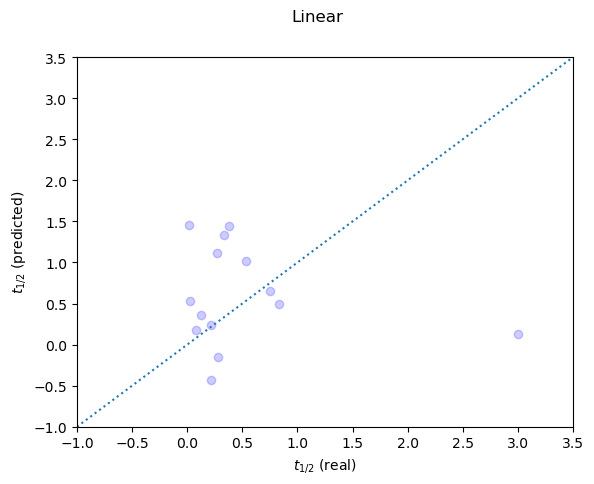

In [23]:
# opakovat pre rozne strojove metody, porovnat chyby

# !!! příp. zjednodušit volání pomocí for loop

type_ml_use = 'linear'
reg, plot_title = model_choice(type_ml_use)
mach_learn(x_train, x_test, y_train, y_test, reg, plot_title)

using ML type KRR
MAE train: 0.2274
MAE test: 0.6352


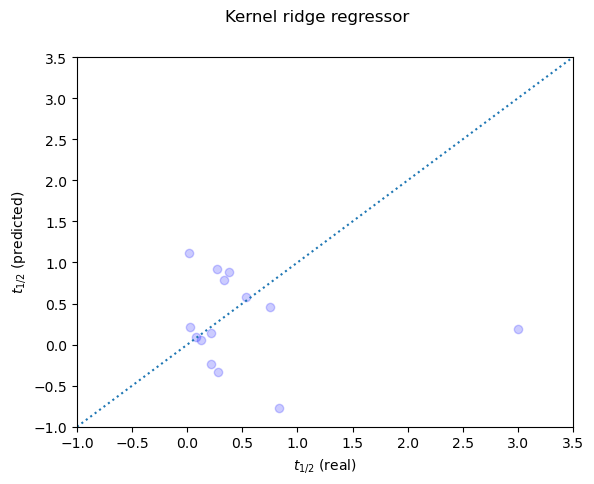

In [24]:
type_ml_use = 'KRR'
reg, plot_title = model_choice(type_ml_use)
mach_learn(x_train, x_test, y_train, y_test, reg, plot_title)

using ML type RF
MAE train: 0.3392
MAE test: 0.5554


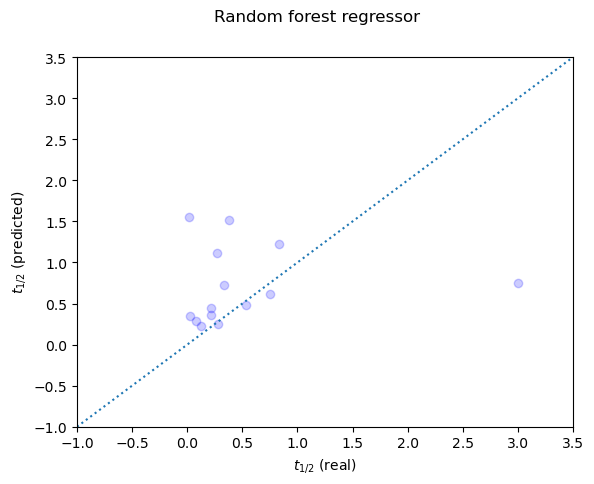

In [25]:
type_ml_use = 'RF'
reg, plot_title = model_choice(type_ml_use)
mach_learn(x_train, x_test, y_train, y_test, reg, plot_title)

using ML type GB
MAE train: 0.2144
MAE test: 0.3618


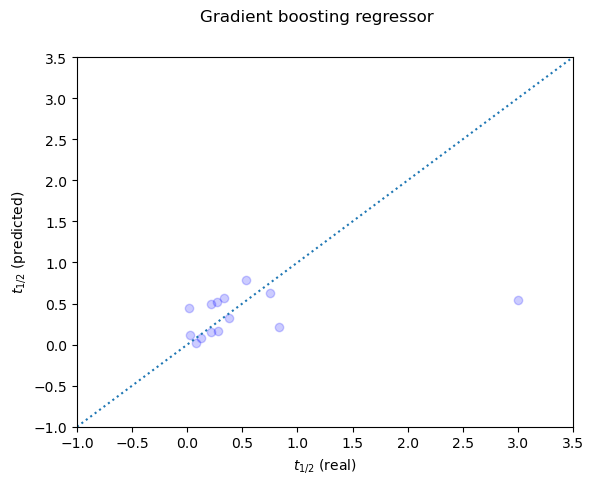

In [26]:
type_ml_use = 'GB'
reg, plot_title = model_choice(type_ml_use)
mach_learn(x_train, x_test, y_train, y_test, reg, plot_title)

using ML type ANN
MAE train: 0.2984
MAE test: 0.4429


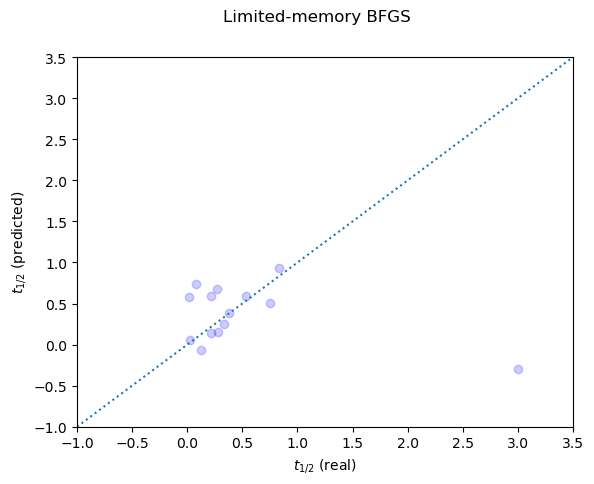

In [27]:
type_ml_use = 'ANN'
reg, plot_title = model_choice(type_ml_use)
mach_learn(x_train, x_test, y_train, y_test, reg, plot_title)

In [28]:
def param_tuning(x_train, y_train, x_test, y_test, type_ml_use, show_print=False):
    # určování hodnot pro param tuning, lze vylepšit pomocí np.random.randint

    # !!! upravit linear hyperparams aby bylo lepší než před tuning

    if type_ml_use == 'linear':
        param_grid = {
            'fit_intercept': [True],
            'alpha': [1e-5, 1e-4, 1e-3, 1e-2],
            'l1_ratio': [0, 0.1, 0.5, 0.9, 1]
        }
        reg = linear_model.ElasticNet()

    if type_ml_use == 'KRR':
        param_grid = {
            "alpha": np.logspace(-4, 1, 20),
            "gamma": np.logspace(-14, 0, 20),
            "kernel": ['linear', 'laplacian', 'rbf']
        }
        reg = KernelRidge()

    if type_ml_use == 'GB':
        param_grid = {
            'n_estimators': [20, 200, 2000],
            'learning_rate': [0.02, 0.05],
            'max_depth': [1, 2, 3, 5],
            'min_samples_leaf': [5, 10, 20],
            'min_samples_split': [2, 5]
        }
        reg = GradientBoostingRegressor()

    if type_ml_use == 'RF':
        param_grid = {
            'max_depth': [None, 2, 3, 5, 10],
            'max_features': ['auto', 'sqrt', 'log2'],
            'n_estimators': [10, 20, 50, 100, 200],
        }
        reg = RandomForestRegressor()

    if type_ml_use == 'ANN':
        param_grid = {
            'learning_rate_init': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05],
            'hidden_layer_sizes': [[5], [10], [20], [50], [5]*2, [10]*2, [20]*2, [50]*2, [5]*3, [10]*3]
        }
        reg = MLPRegressor()

    grid = GridSearchCV(reg, param_grid, cv=KFold(n_splits=5, shuffle=True), verbose=0)
    grid.fit(x_train, y_train)
    best_reg = grid.best_estimator_
    y_train_predict = best_reg.predict(x_train)
    y_test_predict = best_reg.predict(x_test)
    abs_error = np.abs(y_test_predict-y_test)
    if show_print:
        print(type_ml_use)
    # retrain on best hyperparameters
    best_reg.fit(x_train, y_train)

    return y_train_predict, y_test_predict, abs_error

In [29]:
def to_rdkit_fingerprint(fps):
    rdkit_fingerprints = []
    for prnt in fps:
        bitstring = "".join(prnt.astype(str))
        fp = DataStructs.cDataStructs.CreateFromBitString(bitstring)
        rdkit_fingerprints.append(fp)
    return rdkit_fingerprints

In [30]:
fps = to_rdkit_fingerprint(chembl_fps_filtered_test)
fp2s = to_rdkit_fingerprint(chembl_fps_filtered_train)
tanimoto_similarities = []
for x in fps:
    fpsx = []
    for y in fp2s:
        fpsx.append(DataStructs.TanimotoSimilarity(x,y))
    max_tanimoto = max(fpsx)
    tanimoto_similarities.append(max_tanimoto)
print(tanimoto_similarities, f"length: {len(tanimoto_similarities)}")

[0.810126582278481, 0.40625, 0.5692307692307692, 0.9137931034482759, 0.5679012345679012, 0.8833333333333333, 0.8571428571428571, 0.9154929577464789, 0.9193548387096774, 1.0, 0.6052631578947368, 0.3888888888888889, 0.8529411764705882, 0.3684210526315789] length: 14


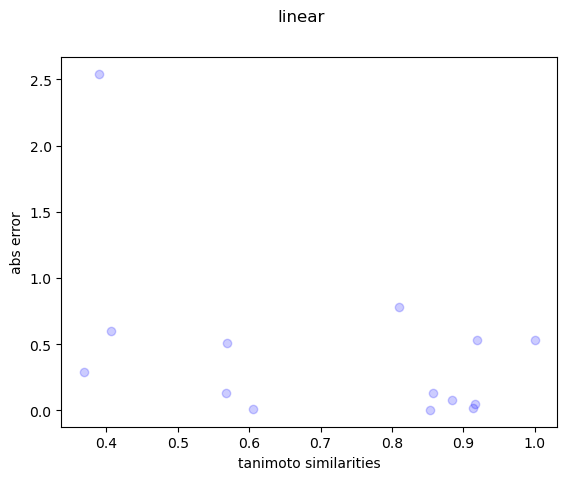

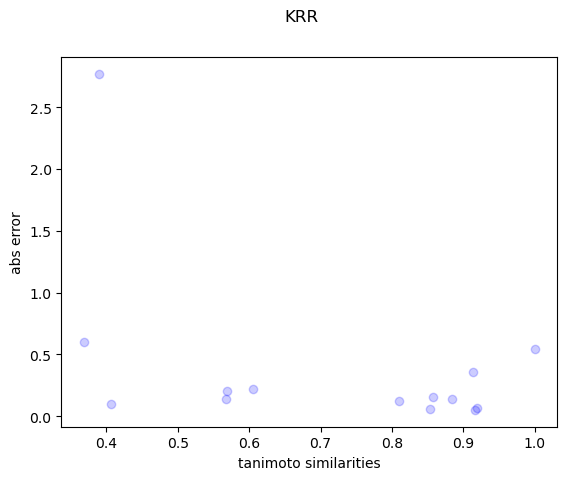

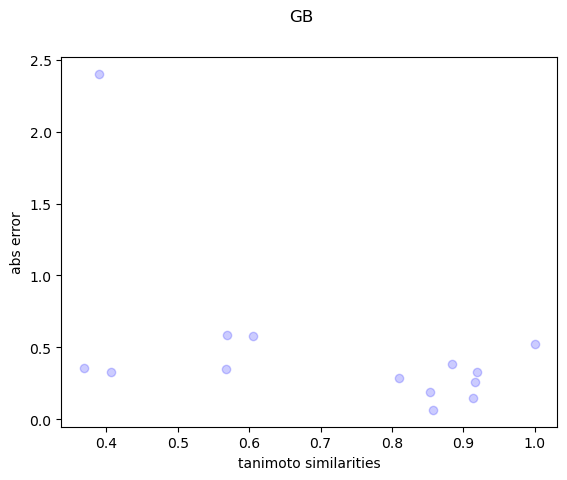

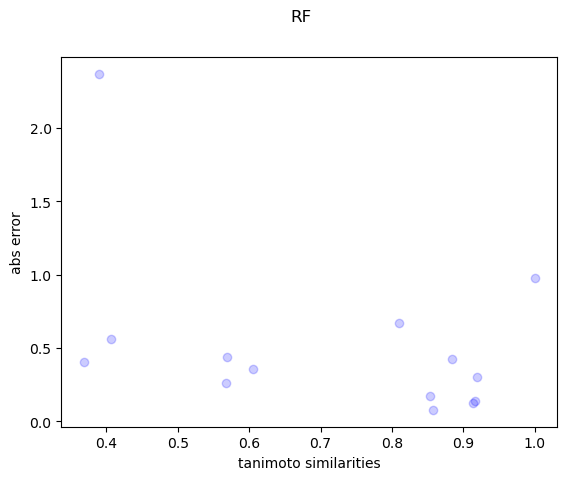

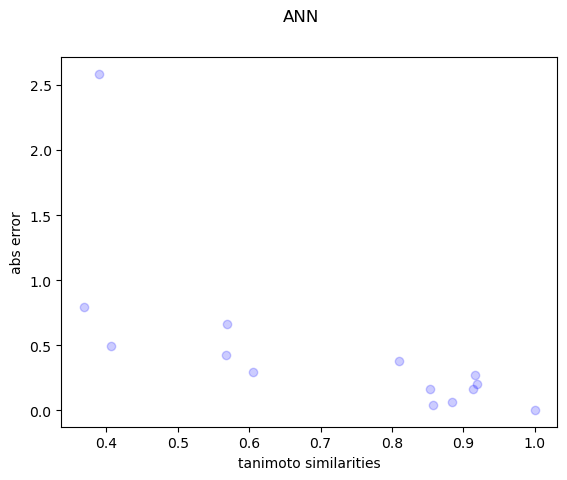

In [31]:
models = ["linear", "KRR", "GB", "RF", "ANN"]
for model in models:
    y_train_predict, y_test_predict, abs_error = param_tuning(x_train, y_train, x_test, y_test, model)
    plot = plt.scatter(tanimoto_similarities, abs_error, edgecolors=None, c='b', alpha=0.2)
    plt.xlabel('tanimoto similarities')
    plt.ylabel('abs error')
    plt.suptitle(f"{model}")
    #plt.savefig(os.path.join(project_results_graphs, plot_title))
    plt.show()

In [32]:
def mean_error(x_train, y_train, x_test, y_test, type_ml_use, show_print=False):
    y_train_predict, y_test_predict, abs_error = param_tuning(x_train, y_train, x_test, y_test, type_ml_use)
    train_error = np.mean(np.abs(y_train_predict-y_train))
    test_error = np.mean(abs_error)
    if show_print:
        print(f"MAE train: {train_error:.4f}")
        print(f"MAE test: {test_error:.4f}")

    return y_test_predict, abs_error

In [33]:
models = ["linear", "KRR", "GB", "RF", "ANN"]
std_dict = {
    "linear": [],
    "KRR": [],
    "GB": [],
    "RF": [],
    "ANN": []
}
mol_err_dict = {
    "linear": [],
    "KRR": [],
    "GB": [],
    "RF": [],
    "ANN": []
}

for model in models:
    y_test_repeated = []

    for i in range(5):
        y_test_out, asdf = mean_error(x_train, y_train, x_test, y_test, model)
        # asdf ... dummy variable, is not needed here
        y_test_repeated.append(y_test_out)

    y_test_repeated_array = np.array(y_test_repeated)

    mol_avg_error = np.average(y_test_repeated_array, axis=0)
    standard_deviation = np.std(y_test_repeated_array, axis=0)

    mol_err_dict[model] = mol_avg_error
    std_dict[model] = standard_deviation
print(f"molecule errors: {mol_err_dict}\n std: {std_dict}")

molecule errors: {'linear': array([ 1.06472067,  0.90867625,  0.64397359,  0.69766031, -0.03244521,
        0.19375678,  0.47086099,  0.18499958,  0.7983642 ,  0.52735533,
        0.07830552,  0.38531915,  0.1945311 ,  0.34450116]), 'KRR': array([0.35739567, 0.3257389 , 0.31127383, 0.45098225, 0.35340111,
       0.42337493, 0.43748466, 0.33516917, 0.40012523, 0.66406179,
       0.34585673, 0.32767282, 0.3079496 , 0.32559798]), 'GB': array([0.80864855, 0.79875818, 0.77522594, 0.79875818, 0.44306573,
       0.75503435, 0.75503435, 0.4567076 , 0.75503435, 0.48678956,
       0.44306573, 0.78511632, 0.42287414, 0.43317536]), 'RF': array([0.85515851, 0.52046101, 0.63178491, 0.55431749, 0.51516379,
       0.61500716, 0.54480662, 0.36659337, 0.54470392, 1.28024274,
       0.57447123, 0.65714409, 0.36314349, 0.5338736 ]), 'ANN': array([0.42646659, 0.21877513, 0.2445746 , 0.45487853, 0.48045361,
       0.34300308, 0.37122301, 0.25284746, 0.36422395, 0.50529356,
       0.41449415, 0.13665312, 0.2

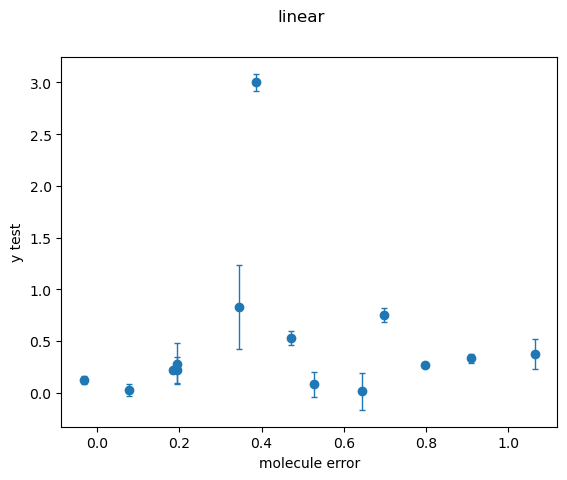

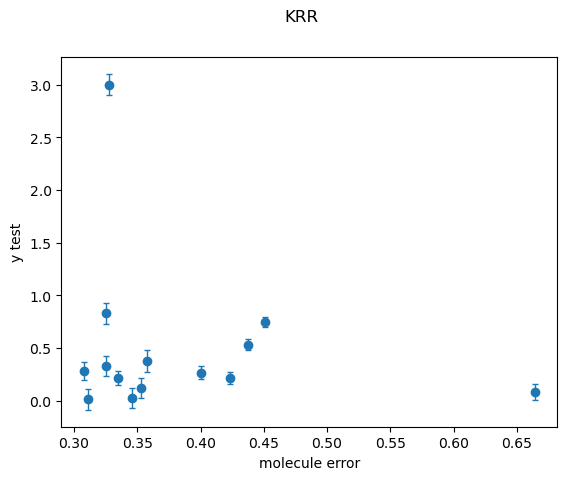

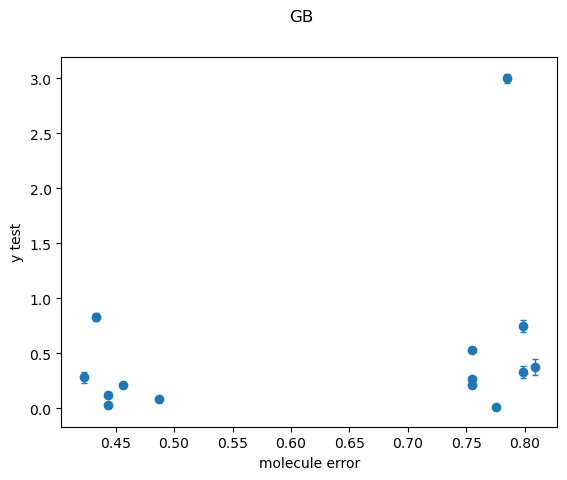

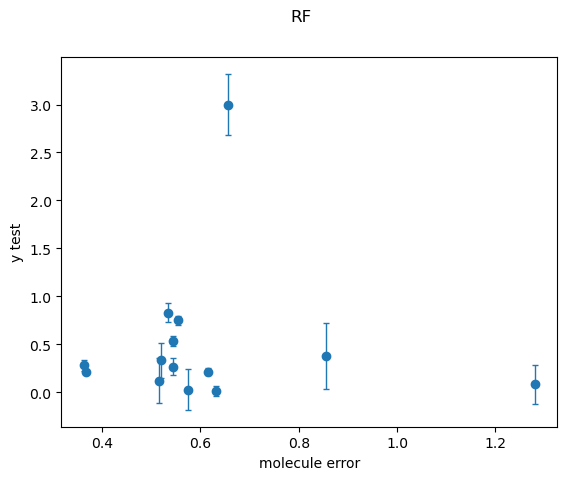

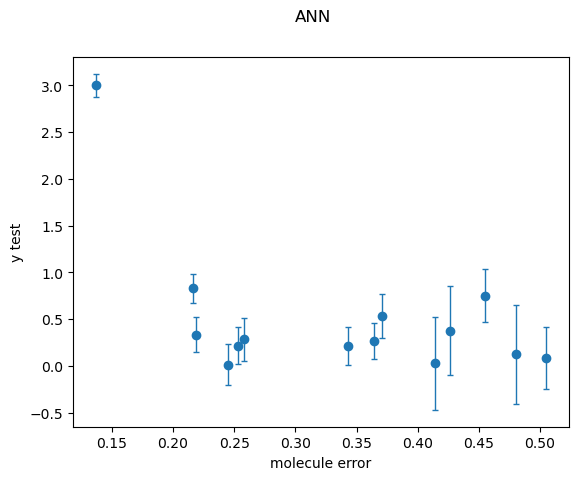

In [38]:
for model in models:
    plt.clf()
    plt.errorbar(mol_err_dict[model], y_test, yerr=std_dict[model], linewidth=1, capsize=2, fmt='o')
    plt.xlabel('molecule error')
    plt.ylabel('y test')
    plt.suptitle(model)
    plt.show()